#Loading Data from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

 95% 311M/329M [00:01<00:00, 168MB/s]
100% 329M/329M [00:01<00:00, 182MB/s]


In [ ]:
! unzip plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

#Data Preprocessing

In [ ]:
import os, shutil

In [ ]:
# # prompt: Write a code to go into PlantVillage and delete all folder except "Tomato_Late_blight,  Tomato_healthy, Potato___Early_blight"

# import os

# # Get the current working directory
# cwd = os.getcwd()

# # Change directory to PlantVillage
# os.chdir(os.path.join(cwd, 'PlantVillage'))

# # Get a list of all folders in PlantVillage
# folders = os.listdir()

# # Create a list of folders to keep
# folders_to_keep = ['Tomato_Late_blight', 'Tomato_healthy', 'Potato___Early_blight']

# # Delete all folders except those in folders_to_keep
# for folder in folders:
#     if folder not in folders_to_keep:
#         shutil.rmtree(folder)


In [ ]:
os.listdir()

['.config', 'PlantVillage', 'plant-village.zip', 'kaggle.json', 'sample_data']

#Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
!pwd

/content


In [ ]:
image_size = 256
batch_size = 32

In [ ]:
!pwd

/content


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle = True,
    image_size = (image_size,image_size),
    batch_size = batch_size,
)

Found 20638 files belonging to 15 classes.


In [ ]:
dataset_classes = dataset.class_names

In [ ]:
len(dataset)

645

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


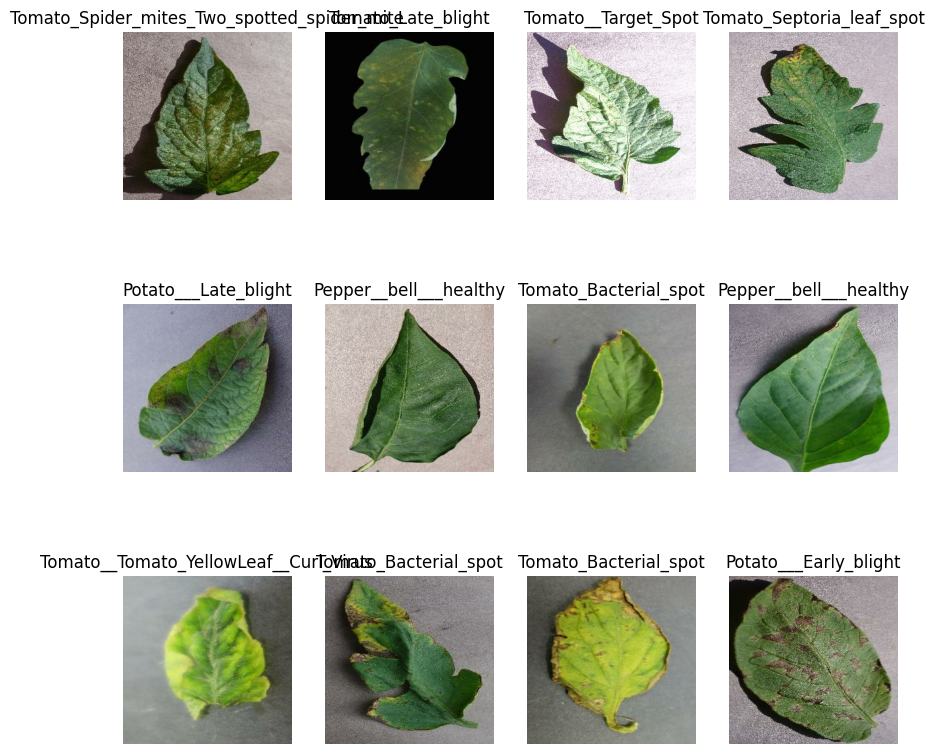

In [ ]:
# dataset.take(1) takes batches data
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print(image_batch[i])
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(type(image_batch[i]))
    plt.title(dataset_classes[(label_batch[i])])
    plt.axis('off')

In [ ]:
def get_dataset(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size =10000):
  ds_len = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(ds_len * train_split)
  val_size = int(ds_len*val_split)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset(dataset)
print(len(train_ds), len(val_ds),len(test_ds))

516 64 65


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)



In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#CNN

In [ ]:
input_shape = (batch_size, image_size, image_size, 3 )
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape =input_shape ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),


])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs =50,
    batch_size = batch_size,
    verbose = 1 ,
    validation_data = val_ds
)

Epoch 1/50


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),loss, label = 'Training loss')
plt.plot(range(50), val_loss, label = 'Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),loss, label = 'Training loss')
plt.plot(range(50), val_loss, label = 'Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
model.save('my_model.h5')

In [ ]:
from google.colab import files
files.download('my_model.h5')